Notebook created by Forrest Hooton

In [3]:
import pandas as pd
import numpy as np
from time import time, sleep
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr
from tqdm import tqdm
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

import urllib.request as request
from lxml import etree

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
import src.pubmed_util as PMD
import src.tools.chemidr.id_map as id_map

In [175]:
f11 = pd.read_pickle('misc_save/garlic_foodb_food.pkl').rename(columns={'pubchem_id' : 'chem_id_p', 'orig_source_name' : 'chemical'})
f11 = f11[f11.standard_content.notnull()]
f12 = pd.read_pickle('misc_save/cocoa_foodb_food.pkl').rename(columns={'pubchem_id' : 'chem_id_p', 'orig_source_name' : 'chemical'})
f12 = f12[f12.standard_content.notnull()]
t11 = pd.concat([
    pd.read_pickle('misc_save/garlic_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})[['chemical', 'chem_id_p']],
    f11[['chemical', 'chem_id_p']],
    pd.read_pickle('misc_save/garlic_usda_conv.pkl').rename(columns={'pubchem_id' : 'chem_id_p'}).rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})[['chemical', 'chem_id_p']],
    pd.read_pickle('misc_save/cocoa_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})[['chemical', 'chem_id_p']],
    f12[['chemical', 'chem_id_p']],
    pd.read_pickle('misc_save/cocoa_usda_conv.pkl').rename(columns={'pubchem_id' : 'chem_id_p'}).rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})[['chemical', 'chem_id_p']]
], ignore_index=True, sort=False, axis=0)
t11 = t11[t11['chem_id_p'].notnull()]
t11['chem_id_p'] = t11['chem_id_p'].apply(int)

f21 = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_foodb_food_dump.pkl').rename(columns={'pubchem_id' : 'chem_id_p', 'orig_source_name' : 'chemical'})
f21 = f21[f21.standard_content.notnull()]
f22 = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_foodb_food_dump.pkl').rename(columns={'pubchem_id' : 'chem_id_p', 'orig_source_name' : 'chemical'})
f22 = f22[f22.standard_content.notnull()]
t22 = pd.concat([
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})[['chemical', 'chem_id_p']],
    f21[['chemical', 'chem_id_p']],
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_usda_conv.pkl').rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})[['chemical', 'chem_id_p']],
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})[['chemical', 'chem_id_p']],
    f22[['chemical', 'chem_id_p']],
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_usda_conv.pkl').rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})[['chemical', 'chem_id_p']]
], ignore_index=True, sort=False, axis=0)
t22 = t22[t22['chem_id_p'].notnull()]
t22['chem_id_p'] = t22['chem_id_p'].apply(int)


In [136]:
s1 = set(t11.chem_id_p.dropna().tolist())
s2 = set(t22.chem_id_p.dropna().tolist())
len(s1), len(s2)
# 8103 in s1

(557, 556)

In [176]:
t11 = t11.drop_duplicates('chem_id_p').reset_index(drop=True)
t22 = t22.drop_duplicates('chem_id_p').reset_index(drop=True)

In [177]:
t11['SMILE'] = id_map.cids2smiles(t11['chem_id_p'].tolist())
t11 = t11[t11.SMILE.notnull()]

t22['SMILE'] = id_map.cids2smiles(t22['chem_id_p'].tolist())
t22 = t22[t22.SMILE.notnull()]


In [178]:
len(t11), len(t22)

(556, 555)

In [34]:
len(set(pd.read_pickle('misc_save/garlic_SMILES.pkl').chem_id_p.tolist()) - set(pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_SMILES.pkl').chem_id_p.tolist()))

3

In [36]:
len(set(pd.read_pickle('misc_save/cocoa_SMILES.pkl').chem_id_p.tolist()) - set(pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_SMILES.pkl').chem_id_p.tolist()))

96

In [44]:
p1 = pd.read_pickle('misc_save/cocoa_SMILES.pkl')
p2 = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_SMILES.pkl')
# len(set(p2.chem_id_p.tolist()) - set(p1.chem_id_p.tolist()))
# display(p1.sort_values('chemical')), display(p2.sort_values('chemical'))
c = p1.merge(p2,how='inner', on='chemical')
c[c.chem_id_p_x != c.chem_id_p_y]

,chemical,chem_id_p_x,SMILE_x,chem_id_p_y,SMILE_y
0,magnesium,5462224,[Mg],888.0,[Mg+2]


In [50]:
p1 = pd.read_pickle('misc_save/cocoa_food_data.pkl').drop(4205, axis=0).reset_index(drop=True).rename(columns={'pubchem_id' : 'chem_id_p'})
p2 = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
c = pd.DataFrame({'x' : p1.chem_id_p.tolist(), 'y' : p2.chem_id_p.tolist()})

c[c.x != c.y].drop_duplicates()

,x,y
1,2723872.0,439709.0
136,NaN,NaN
688,21732.0,NaN
714,12309460.0,NaN
757,12358480.0,3048.0
823,12303035.0,NaN
962,727.0,NaN
1042,NaN,0.0
1129,14421.0,NaN
4572,10430.0,NaN


In [52]:
p1 = pd.read_pickle('misc_save/garlic_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
p2 = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
c = pd.DataFrame({'x' : p1.chem_id_p.tolist(), 'y' : p2.chem_id_p.tolist()})

c[c.x != c.y].drop_duplicates()

,x,y
7,NaN,NaN
289,9914062.0,12304825.0
658,102060556.0,NaN
728,9881148.0,NaN


# Note: Go directly to "TSNE Vizualizations" section to run plots with TSNE transformation used in paper.

In [188]:
# food = 'garlic'
food = 'cocoa'

food_data = pd.read_pickle('misc_save/' + food + '_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
foodb_food = pd.read_pickle('misc_save/' + food + '_foodb_food.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
usda = pd.read_pickle('misc_save/' + food + '_usda_conv.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})

# food_data = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/' + food + '_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
# foodb_food = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/' + food + '_foodb_food_dump.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
# usda = pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/' + food + '_usda_conv.pkl')

# food_data = pd.concat([pd.read_pickle('misc_save/garlic_food_data.pkl'), pd.read_pickle('misc_save/cocoa_food_data.pkl')], axis=0, ignore_index=True,sort=False).rename(columns={'pubchem_id' : 'chem_id_p'})
# foodb_food = pd.concat([pd.read_pickle('misc_save/garlic_foodb_food.pkl'), pd.read_pickle('misc_save/cocoa_foodb_food.pkl')], axis=0, ignore_index=True,sort=False).rename(columns={'pubchem_id' : 'chem_id_p'})
# usda = pd.concat([pd.read_pickle('misc_save/garlic_usda_conv.pkl'), pd.read_pickle('misc_save/cocoa_usda_conv.pkl')], axis=0, ignore_index=True,sort=False).rename(columns={'pubchem_id' : 'chem_id_p'})

foodb_food = foodb_food[foodb_food.standard_content.notnull()]

foodb_food = foodb_food.rename(columns={'name' : 'chemical', 'standard_content':'average_mean'})
usda = usda.rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})

food_data['source'] = 'pilot'
foodb_food['source'] = 'FooDB'
usda['source'] = 'USDA'

In [77]:
len(food_data), len(foodb_food), len(usda)

(1426, 419, 151)

In [189]:
def filt(df, simple=False):
    
    if simple:
        df = df[['chemical', 'chem_id_p']].drop_duplicates()
    else:
        df = df[['chemical', 'chem_id_p', 'average_mean', 'source']].drop_duplicates()
    
    df = df[df['chem_id_p'].notnull()]
    df['chem_id_p'] = df['chem_id_p'].apply(int)
    
    return df.reset_index(drop=True)

chems = pd.concat([filt(food_data, simple=True), 
                   filt(foodb_food, simple=True),
                   filt(usda, simple=True)]).drop_duplicates(subset='chem_id_p').reset_index(drop=True)

In [183]:
import importlib
importlib.reload(id_map)

<module 'chemidr.id_map' from 'C:\\Users\\forresthooton\\Documents\\NetSci Research\\Foodome Project\\Chemidr\\chemidr\\id_map.py'>

In [174]:
# chems[chems.chem_id_p == 8103]
# # t11[t11.chem_id_p == 8103]
chems[chems['SMILE'].isnull()]


,chemical,chem_id_p,SMILE
508,phosphatidylcholine,0,NaN


In [190]:
# Retrieve SMILES from PubChem using cid's
chems['SMILE'] = id_map.cids2smiles(chems['chem_id_p'].tolist())
chems = chems[chems.SMILE.notnull()]

In [125]:
t = pd.concat([
    pd.read_pickle('misc_save/garlic_fingerprints.pkl'),
    pd.read_pickle('misc_save/cocoa_fingerprints.pkl')
], axis = 0, ignore_index=True, sort=False).drop_duplicates('chem_id_p').merge(chems, how='left', on='chem_id_p')
t[t.chemical_y.isnull()]

,chemical_x,chem_id_p,SMILE_x,fingerprint,chemical_y,SMILE_y
215,1-hexanol,8103,CCCCCCO,2246728737 3542456614 2245384272 1173125914 22...,NaN,NaN
216,allyl alcohol,7858,C=CCO,2246997334 3696402029 2246703798 535847852 224...,NaN,NaN
217,thiamine monochloride,6042,CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCO.[Cl-],2246728737 422715066 3217380708 3274018096 321...,NaN,NaN
218,4-methyl-5-vinylthiazole,15654,CC1=C(SC=N1)C=C,2246728737 422715066 3217380708 4033380444 321...,NaN,NaN
219,"(+/-)-cis- and trans-3,5-diethyl-1,2,4-trithio...",520895,CCC1SC(SS1)CC,2246728737 3542456614 2245384272 3594356142 29...,NaN,NaN
...,...,...,...,...,...,...
297,naringenin,932,C1C(OC2=CC(=CC(=C2C1=O)O)O)C3=CC=C(C=C3)O,2968968094 1824088295 2976033787 2531774451 31...,NaN,NaN
298,"theaflavin-3,3'-digallate",21146795,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC4=C(C(=C(C=C4C5...,2968968094 1824088295 2976033787 1228528465 29...,NaN,NaN
299,theaflavin-3'-gallate,22833650,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=O)C(=C4C(=C3)...,2968968094 1824088295 2976033787 1228528465 29...,NaN,NaN
300,theaflavin-3-gallate,4657307,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C4=C(C(=O)C...,2968968094 1824088295 2976033787 1228528465 29...,NaN,NaN


In [191]:
# chems.to_pickle('misc_save/' + food + '_SMILES.pkl')
chems = pd.read_pickle('misc_save/' + food + '_SMILES.pkl')

In [113]:
len(pd.read_pickle('misc_save/garlic_SMILES.pkl')), len(pd.read_pickle('misc_save/cocoa_SMILES.pkl'))

(302, 293)

In [111]:
len(set(pd.read_pickle('misc_save/garlic_SMILES.pkl').chem_id_p.tolist() + pd.read_pickle('misc_save/cocoa_SMILES.pkl').chem_id_p.tolist() ))

532

# Fingerprint Analysis

In [192]:
def get_ordered_fingerprint_string(SMILE):
    # Obtain dictionary of fingerprints and order
    bi = {}
    AllChem.GetMorganFingerprint(Chem.MolFromSmiles(SMILE), radius=1, bitInfo=bi)

    # Iterate over dictionary to store as pd.Series
    mol = pd.DataFrame()
    for key, value in bi.items():
        for i in range(len(value)):
            sub = pd.Series()
            sub['val'] = str(key)

            sub['order'] = value[i][0]
            sub['radius'] = value[i][1]

            mol = mol.append(sub, ignore_index=True)

    # Correctly order fingerprint
    mol = mol.sort_values(by=['order', 'radius']).reset_index(drop=True)

    # Convert ordered fingerprint into single string
    mol_string = " ".join(mol.val.tolist())
        
    return mol_string.strip()

for idx, row in tqdm(chems.iterrows()):
    chems.at[idx, 'fingerprint'] = get_ordered_fingerprint_string(row['SMILE'])

389it [02:13,  2.91it/s]


In [193]:
# chems.to_pickle('misc_save/' + food + '_fingerprints.pkl')
chems = pd.read_pickle('misc_save/' + food + '_fingerprints.pkl')

In [108]:
len(pd.read_pickle('misc_save/garlic_fingerprints.pkl')), len(pd.read_pickle('misc_save/cocoa_fingerprints.pkl'))

(302, 293)

In [114]:
# len(set(pd.read_pickle('misc_save/garlic_fingerprints.pkl').chem_id_p.tolist() + pd.read_pickle('misc_save/cocoa_fingerprints.pkl').chem_id_p.tolist() ))
chems[chems.SMILE.isnull()]

,chemical,chem_id_p,SMILE,fingerprint


After creating the fingerprints for both garlic and cocoa...

In [194]:
chems = pd.concat([
    pd.read_pickle('misc_save/garlic_fingerprints.pkl'),
    pd.read_pickle('misc_save/cocoa_fingerprints.pkl')
], axis = 0, ignore_index=True, sort=False)

chems = chems.drop_duplicates('chem_id_p')

In [195]:
chems.chem_id_p = chems.chem_id_p.apply(int)
len(chems.drop_duplicates('chem_id_p'))
len(set(chems.chem_id_p))

556

In [54]:
chems1 = pd.concat([
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/garlic_fingerprints.pkl'),
    pd.read_pickle('/Users/forresthooton/Dropbox/PDFs/paper_ranking/misc_save/cocoa_fingerprints.pkl')
], axis = 0, ignore_index=True, sort=False)

chems1 = chems1.drop_duplicates('chem_id_p')

In [60]:
len(set(pd.read_pickle('misc_save/garlic_SMILES.pkl').chem_id_p.tolist() + pd.read_pickle('misc_save/cocoa_SMILES.pkl').chem_id_p.tolist()))

532

In [77]:
c = chems.merge(chems1, how='left', on='chemical')
c[c.chem_id_p_y.isnull()]

,chemical,chem_id_p_x,SMILE_x,fingerprint_x,chem_id_p_y,SMILE_y,fingerprint_y
123,antimony (iii),102060556,[HH].[Sb],4277646599 1312309676,NaN,NaN,NaN
125,z-ajoene,9881148,C=CCSSC=CCS(=O)CC=C,2246997334 3696402029 2246703798 535847852 224...,NaN,NaN,NaN
302,myo-inositol,892,C1(C(C(C(C(C1O)O)O)O)O)O,2976033787 675765711 2976033787 675765711 2976...,NaN,NaN,NaN
303,mannitol,6251,C(C(C(C(C(CO)O)O)O)O)O,2245384272 4022716898 2245273601 1735424888 22...,NaN,NaN,NaN
304,melibiose,440658,C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)O)O)O)O)O)O)O)O,2245384272 3153477100 2976033787 1916236386 29...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
365,pentanal,8063,CCCCC=O,2246728737 3542456614 2245384272 1173125914 22...,NaN,NaN,NaN
366,3-hydroxy-2-butanone,179,CC(C(=O)C)O,2246728737 3537119515 2245273601 2579634572 22...,NaN,NaN,NaN
367,hexanal,6184,CCCCCC=O,2246728737 3542456614 2245384272 1173125914 22...,NaN,NaN,NaN
368,acetic acid,176,CC(=O)O,2246728737 3545365497 2246699815 2205501948 86...,NaN,NaN,NaN


In [104]:
t22[t22.chemical.fillna('-').str.contains('acetic acid')]
# chems1[chems1.chem_id_p == 176.0]

,chemical,chem_id_p,SMILE,fingerprint


In [196]:
from collections import Counter

fingerprints = [f.split() for f in chems.fingerprint.tolist()]

f_flattened = [c for f in fingerprints for c in f]

f_counts = Counter(f_flattened)

In [197]:
import re

unks = []

for key, value in f_counts.items():
    if value <= 3:
        unks.append(re.escape(key))
        
unk_regex = '(' + ')|('.join(unks) + ')'

for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint'] = re.sub(unk_regex, 'UNK', row['fingerprint'])

In [198]:
fingerprints = [f.split() for f in chems.fingerprint.tolist()]

dim_embedding = 100

model = Word2Vec(fingerprints, size=dim_embedding, sg=1, window=5, min_count=1, workers=4)
model.train(fingerprints, total_examples=model.corpus_count, epochs=model.epochs)

(37133, 87295)

In [199]:
def calc_fingerprint_vector(model, fingerprint):
    fingerprints = fingerprint.split()
    
    # Extract substructure embeddigns
    fingerprint_substructures = [model.wv[f] for f in fingerprints]
    
    # Sum substructure embeddings to create molecule vector
    fingerprint_vector = np.mean(fingerprint_substructures, axis=0)
    
    # Store fingerprint vector as string
    fingerprint_vector = ' '.join([str(i) for i in fingerprint_vector])
    
    return fingerprint_vector
    
for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint_vector'] = calc_fingerprint_vector(model, row['fingerprint'])
    

# Dimensinality Reduction and Visualization

In [200]:
# Consolidates matching chemicals in that appear in multiple databases
def clean_source(data):
    consolidated_data = pd.DataFrame()
    for ID in data.chem_id_p.drop_duplicates().tolist():
        temp = data[data.chem_id_p == ID].copy().reset_index(drop=True)

        if len(temp) > 1:

            if len(set(temp.source.tolist())) == 1:
                sources = temp.source.tolist()[0]
            else:
                sources = "-".join(list(set(temp.source.tolist())))

            new_row = pd.Series()
            new_row['chemical'] = temp.loc[0, 'chemical']
            new_row['chem_id_p'] = temp.loc[0, 'chem_id_p']
            new_row['SMILE'] = temp.loc[0, 'SMILE']
            new_row['fingerprint'] = temp.loc[0, 'fingerprint']
            new_row['fingerprint_vector'] = temp.loc[0, 'fingerprint_vector']
            new_row['average_mean'] = temp.average_mean.mean()
            new_row['source'] = sources

            consolidated_data = consolidated_data.append(new_row, ignore_index=True)

        else:
            consolidated_data = consolidated_data.append(temp, ignore_index=True)
            
    return consolidated_data

In [208]:
def load_classes():
    foodb_class = pd.read_csv('data/compounds.csv', encoding='latin1')[['id', 'name', 'superklass', 'klass', 'subklass']]
    foodb_class.name = foodb_class.name.str.lower()
    fdb_class_keys = foodb_food.merge(foodb_class, how='left', left_on = 'chemical', right_on = 'name')[['chem_id_p', 'superklass', 'klass', 'subklass']]
    fdb_class_keys.columns = ['chem_id_p', 'SuperClass', 'Class', 'SubClass']

    labeled_classdata = pd.read_pickle('data/' + food + '_chem_class.pkl')[['SuperClass', 'Class', 'SubClass', 'chem_id_p']]

    classdata = pd.concat([fdb_class_keys, labeled_classdata])
    classdata = classdata[classdata.chem_id_p.notnull()].drop_duplicates(subset='chem_id_p')
    classdata.SuperClass = classdata.SuperClass.str.lower()
    
    return classdata

def load_health():
    # Read in CTD data
    skip = list(range(26)) # First few lines are empty / not useful info
    hdata = pd.read_csv('data/CTD_chemicals_diseases.csv', skiprows=skip).reset_index()
    hdata.columns = ['ChemicalName', 'ChemicalID', 'CasRN', 'DiseaseName', 'DiseaseID', 'DirectEvidence', 'InferenceGeneSymbol', 'InferenceScore', 'OmimIDs', 'PubMedIDs']
    hdata = hdata.drop([0,1], axis = 0).reset_index(drop=True)

    # Pubchem ids of all chemicals in CTD
    health_pubchem_ids = pd.read_pickle('misc_save/health_chem_pubchem_ids.pickle').drop('pubchem_name', axis=1)

    hdata = hdata.merge(health_pubchem_ids, how='left', on='ChemicalName')

    # Count the number of 'Direct Evidence' listings per chemical with a pubchem id
    de_health = pd.DataFrame(
        hdata[hdata.pubchem_id.notnull() & hdata.DirectEvidence.notnull()][['pubchem_id', 'DirectEvidence', 'ChemicalName']]
        .groupby(['pubchem_id','DirectEvidence']).count()).reset_index()
    
    # The 'ChemicalName' now holds the count of 'Direct Evidence' listings
    return de_health[['pubchem_id', 'ChemicalName']].groupby('pubchem_id').sum()

In [219]:
food_mine = pd.read_pickle('misc_save/' + food + '_quant_fm.pkl')
food_mine['source'] = 'FoodMine'

# Combine data sources and add fingerprints to compounds
data = pd.concat([filt(food_mine), filt(foodb_food), filt(usda)])
data = chems.merge(data.drop(columns='chemical'), how='left', on = 'chem_id_p')
data = data.merge(load_classes(), how='left', on = 'chem_id_p')

# Clean sources and combine them
data = clean_source(data)

# Add CTD data
data = data.merge(load_health(), how='left', left_on = 'chem_id_p', right_on = 'pubchem_id')

data.ChemicalName = data.ChemicalName.fillna(0)

c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (13,14,17,45,50,51,54,55,62,63,64,65,66,67,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [220]:
# Extract list of fingerprint vectors for TSNE
dr_data = [[float(f) for f in v.split()] for v in data.fingerprint_vector.tolist()]

In [221]:
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(dr_data)

In [232]:
target_col = 'Number of Health Associations'

# viz_data = pd.DataFrame(tsne_fit, columns = ['tsne_0', 'tsne_1'])

# viz_data['source'] = data.source.tolist()
# viz_data['chemical'] = data.chemical.tolist()
# viz_data['class'] = data.SuperClass.fillna('NA').tolist()
# viz_data['Number of Health Associations'] = data.ChemicalName.fillna(0).tolist()

In [234]:
"""
    To exactly reproduce plot points from paper, must load the previously generated TSNE points.
"""
viz_data = pd.read_pickle(f'data/{food}_chemical_viz_data.pkl')

# TSNE Vizualizations

[Text(1, 0, '1'),
 Text(1, 0, '3'),
 Text(1, 0, '7'),
 Text(1, 0, '20'),
 Text(1, 0, '55'),
 Text(1, 0, '148')]

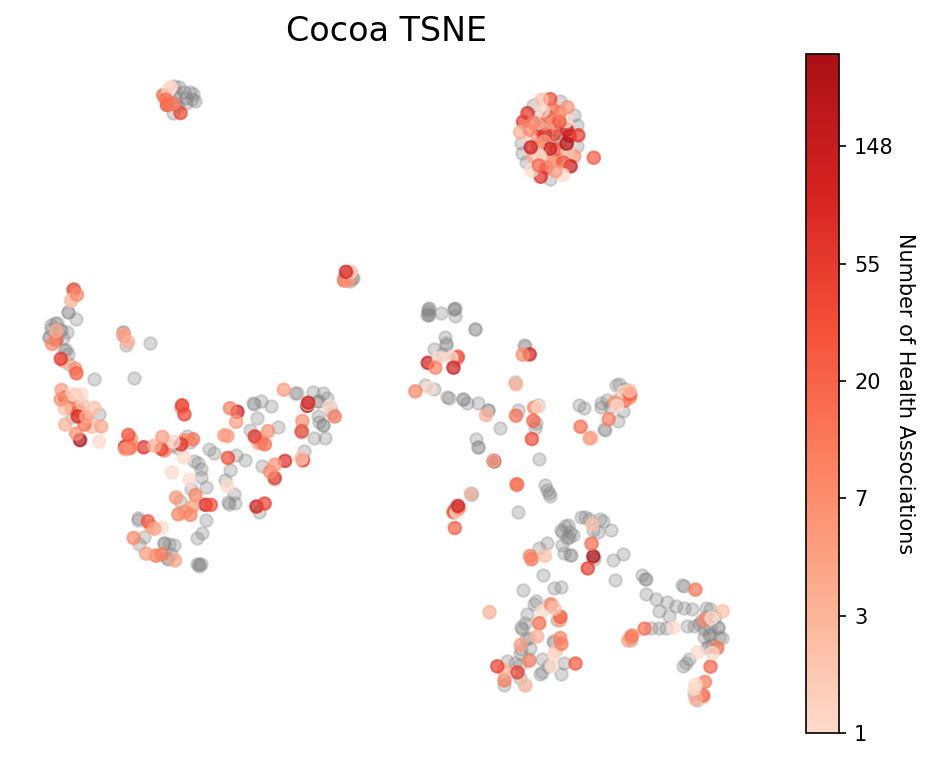

In [235]:
target_col = 'Number of Health Associations'

_, ax = plt.subplots(figsize=(8,6))

# Seperate 0 and non-zero data
v1 = viz_data[viz_data[target_col] != 0]
v2 = viz_data[viz_data[target_col] == 0]

color_values = v1[target_col].apply(np.log).tolist()
#color_values = v1[target_col].tolist()

#min_c_val = -11.6 # min(color_values) # Need to change to make colorbars same
#max_c_val = 11.3 #max(color_values)

min_c_val = min(color_values)
max_c_val = max(color_values)

levels = np.linspace(min_c_val, max_c_val, 10)

# Plot data with 0 in grey
ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
           marker='o', alpha=.3)

# Plot non-zero data accoring to color bar
f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
           cmap=clr.LinearSegmentedColormap.from_list('map1', sns.color_palette("Reds").as_hex(), N=10000),
               marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

ax.set_title(f'{food.capitalize()} TSNE', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axis('off')

cbar = plt.colorbar(f)
cbar.set_label(target_col, rotation=270, labelpad=+10)

ticks = cbar.get_ticks()
cbar.ax.set_yticklabels([int(round(np.exp(t))) for t in ticks])

248


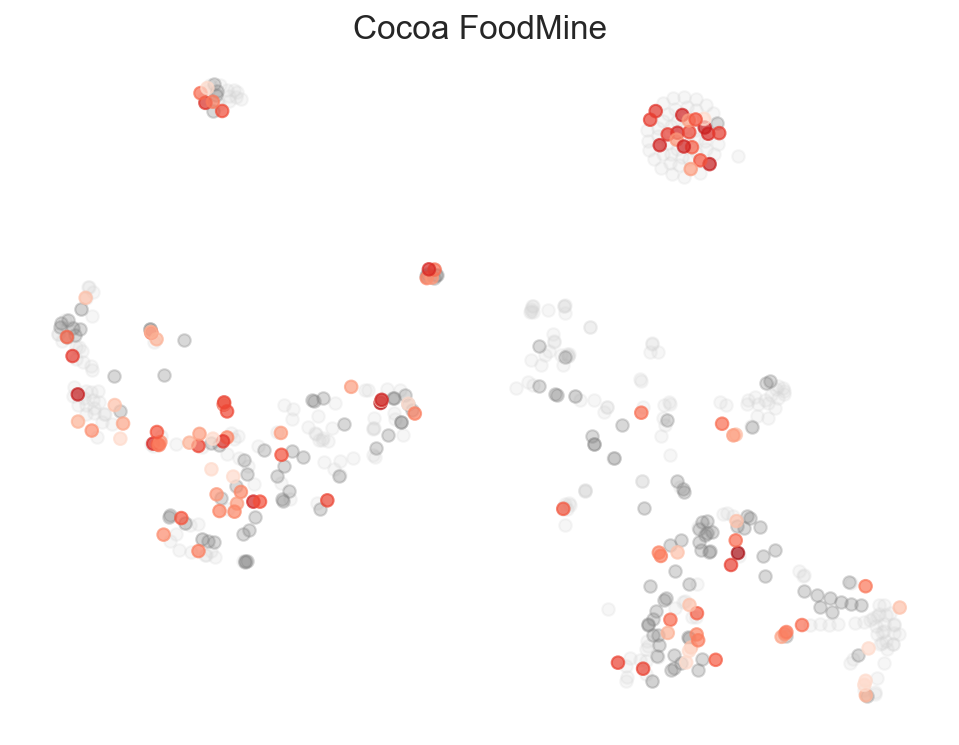

104


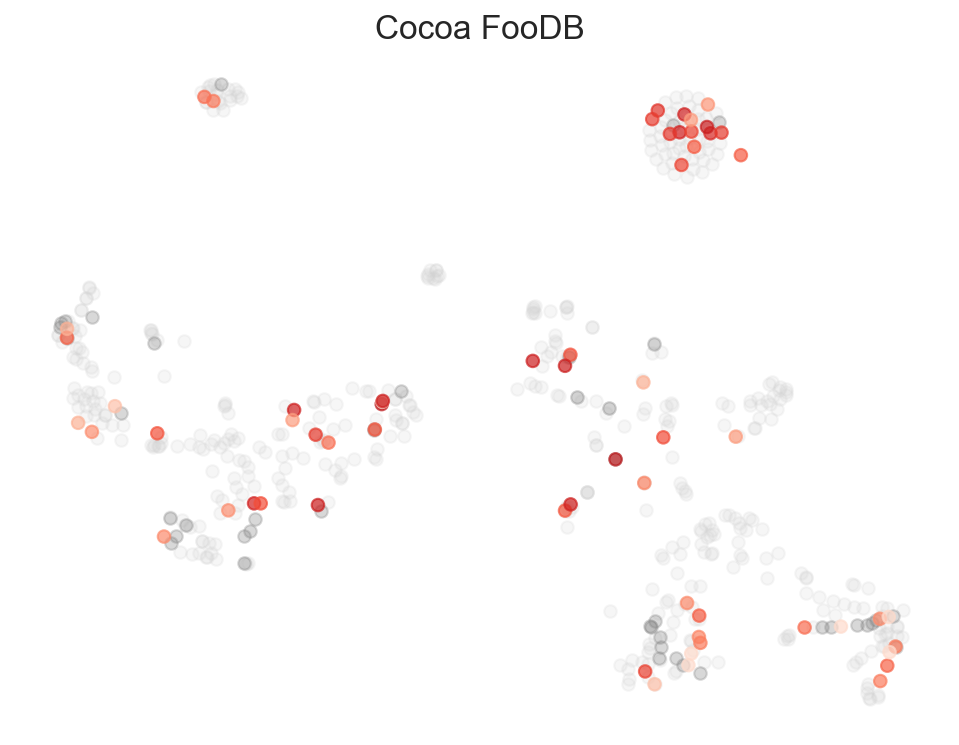

80


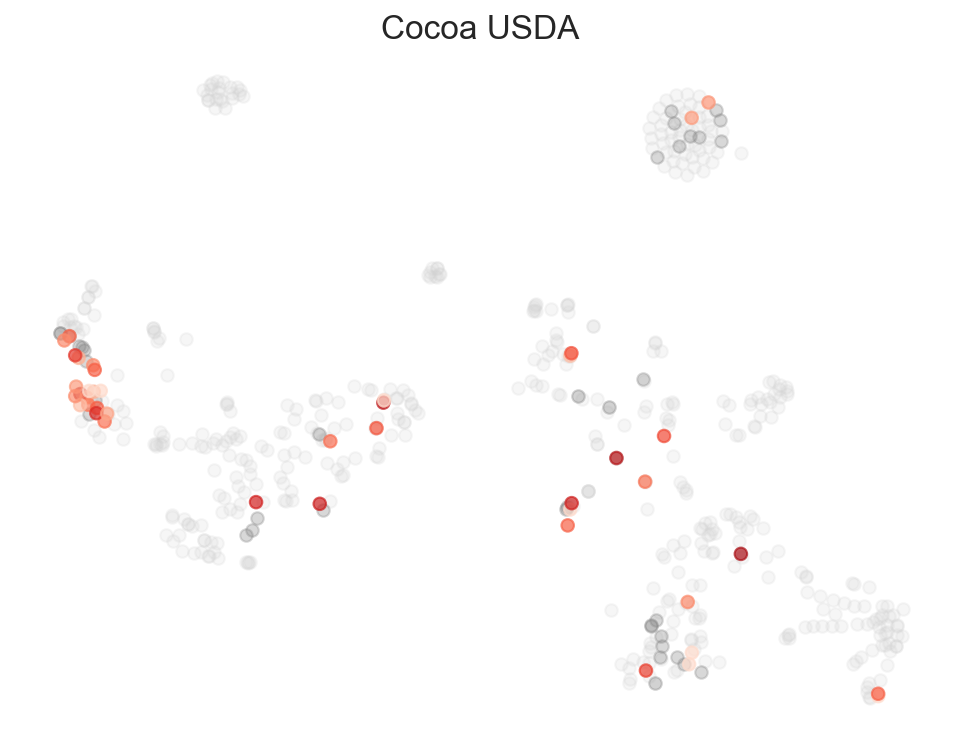

In [236]:
source_strings = ['FoodMine', 'FooDB', 'USDA']

main_color = 'Reds'
color_pals = {
    'FoodMine' : clr.LinearSegmentedColormap.from_list('map1', sns.color_palette(main_color).as_hex()),
    'FooDB' : clr.LinearSegmentedColormap.from_list('map2', sns.color_palette(main_color).as_hex()),
    'USDA' : clr.LinearSegmentedColormap.from_list('map3', sns.color_palette(main_color).as_hex())
}

# Plot each datasource as seperate graph
for s in source_strings:
    # Seperate values in datasource from values not in datasource
    temp = viz_data[viz_data.source.fillna('NA').str.contains(s)]
    antitemp = viz_data[~viz_data.source.fillna('NA').str.contains(s)]
    
    print(len(temp))
    
    with sns.axes_style('white'):
        _, ax = plt.subplots(figsize=(8,6))

        color_values = temp[target_col].apply(np.log).tolist()
        
        # Plot values not in datasource as lightgrey
        ax.scatter(antitemp.tsne_0.tolist(), antitemp.tsne_1.tolist(), c='lightgrey',
                   marker='o', alpha=.2)

        v1 = temp[temp[target_col] != 0]
        v2 = temp[temp[target_col] == 0]

        color_values = v1[target_col].apply(np.log).tolist()
        
        # Plot values in datasource with a value of 0 as grey
        ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
                   marker='o', alpha=.3)
        
        # Plot values in datasource with a nonzero value in the colormap color
        f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
                   cmap=color_pals[s], marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

        ax.set_title(food.capitalize() + ' ' + s, fontsize=16)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.axis('off')

        plt.show()

In [237]:
import matplotlib as mpl

classdata = load_classes()

class_labels = classdata.SuperClass.drop_duplicates().dropna().tolist()
p = sns.color_palette('muted', n_colors=len(class_labels)).as_hex()

colors = {l : p[i] for i, l in enumerate(class_labels)}

c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (13,14,17,45,50,51,54,55,62,63,64,65,66,67,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


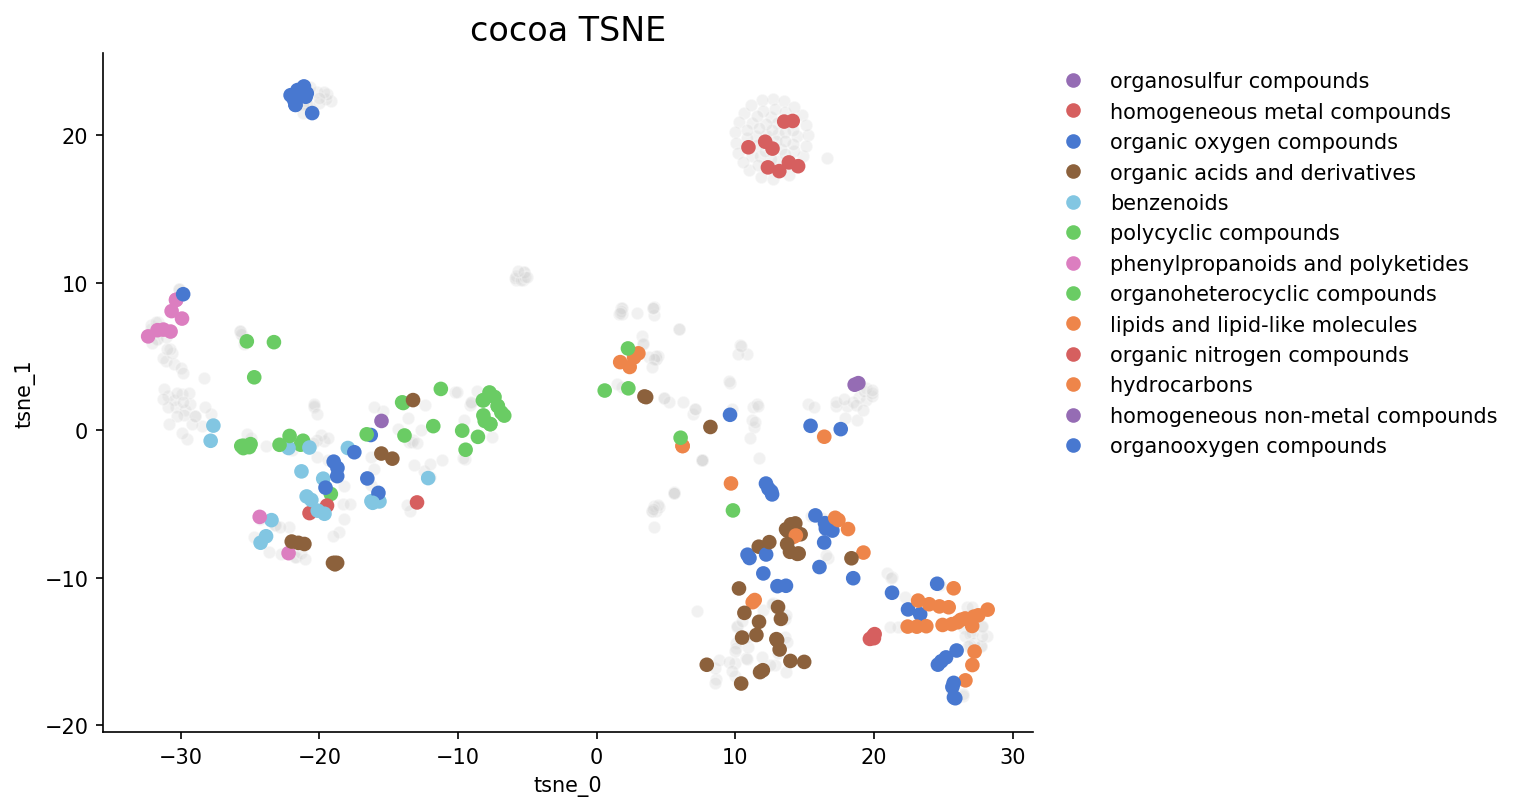

In [238]:
v1 = viz_data[viz_data['class'] != 'NA']
v2 = viz_data[viz_data['class'] == 'NA']

_, _ = plt.subplots(figsize=(8,6))

ax = sns.scatterplot(x='tsne_0', y='tsne_1', color='lightgrey', alpha=.3, data=v2)
ax.scatter(v1['tsne_0'].tolist(), v1['tsne_1'].tolist(), c=[colors[l] for l in v1['class'].tolist()])

ax.set_title(f'{food} TSNE', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

patches = [mpl.lines.Line2D([0], [0], color=colors[s], label=s, marker='o', linewidth=0) for s in v1['class'].drop_duplicates().tolist()]
ax.legend(handles = patches, frameon = False, loc='upper left', bbox_to_anchor=(1, 1))